<a href="https://colab.research.google.com/github/igrodfer/DeepLearningLab/blob/main/cifar10_9200.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install visualkeras

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 992.2/992.2 KB 14.9 MB/s eta 0:00:00


In [2]:
import keras
from keras.datasets import cifar10
from keras.layers import Input
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D, Add
from keras.layers import BatchNormalization as BN
from keras.layers import GaussianNoise as GN
from tensorflow.keras.optimizers import SGD, Adam
from keras.utils import np_utils
from keras import Input, Model
from keras.callbacks import LearningRateScheduler as LRS
from keras.preprocessing.image import ImageDataGenerator
from keras.utils.vis_utils import plot_model
import visualkeras

In [14]:
batch_size = 100
num_classes = 10
epochs = 200

In [4]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

x_train /= 255
x_test /= 255

print(x_train.shape)
print(x_test.shape)

y_train = keras.utils.np_utils.to_categorical(y_train, num_classes)
y_test = keras.utils.np_utils.to_categorical(y_test, num_classes)

170498071/170498071 [==============================] - 2s 0us/step
(50000, 32, 32, 3)
(10000, 32, 32, 3)


In [5]:
datagen = ImageDataGenerator(
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    rotation_range=20,
    shear_range=0.2,
    zoom_range=0.2)

In [6]:
def resblock(x, filters,ds=False):
  fx = Conv2D(filters, (3,3), strides=(2 if ds else 1), padding='same')(x)
  fx = BN()(fx)
  fx = GN(0.3)(fx)
  fx = Activation('relu')(fx)

  fx = Conv2D(filters, (3,3), padding='same')(fx)
  
  if filters != x.shape[-1] or ds:
    stride = 2 if ds else 1
    print(stride)
    x = Conv2D(filters, (1,1),strides=stride, padding='same')(x)

  print(x.shape)

  fx = Add()([x,fx])

  fx = BN()(fx)
  fx = GN(0.3)(fx)
  out = Activation('relu')(fx)

  return out

In [7]:
def CBGN(x,filters,ishape=0):
  if (ishape!=0):
    fx = Conv2D(filters, (3, 3), padding='same',
                 input_shape=ishape)(x)
  else:
    fx = Conv2D(filters, (3, 3), padding='same')(x)
  
  fx = BN()(fx)
  fx = GN(0.3)(fx)
  fx = Activation('relu')(fx)
  
  return fx

In [15]:
n = 2

input = Input(shape=x_train.shape[1:])

out = CBGN(input,16)
out = resblock(out,32*n)
out = resblock(out,32*n)

out = resblock(out,64*n,True)
out = resblock(out,64*n)


out = resblock(out,128*n,True)
out = resblock(out,128*n)

out = Flatten()(out)
out = Dense(512)(out)
out = BN()(out)
out = GN(0.3)(out)
out = Activation('relu')(out)

out = Flatten()(out)
out = Dense(num_classes)(out)
out = Activation('softmax')(out)

model = Model(input,out)

1
(None, 32, 32, 64)
(None, 32, 32, 64)
2
(None, 16, 16, 128)
(None, 16, 16, 128)
2
(None, 8, 8, 256)
(None, 8, 8, 256)


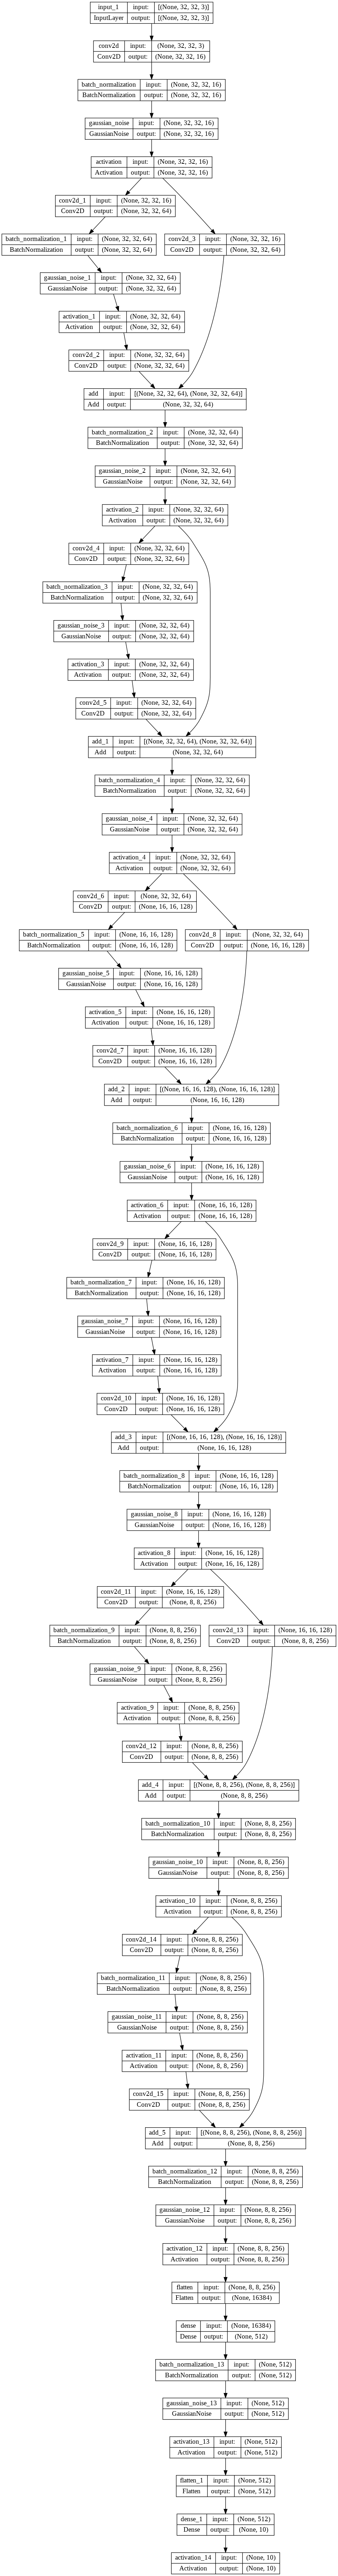

In [9]:
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True,expand_nested=True)

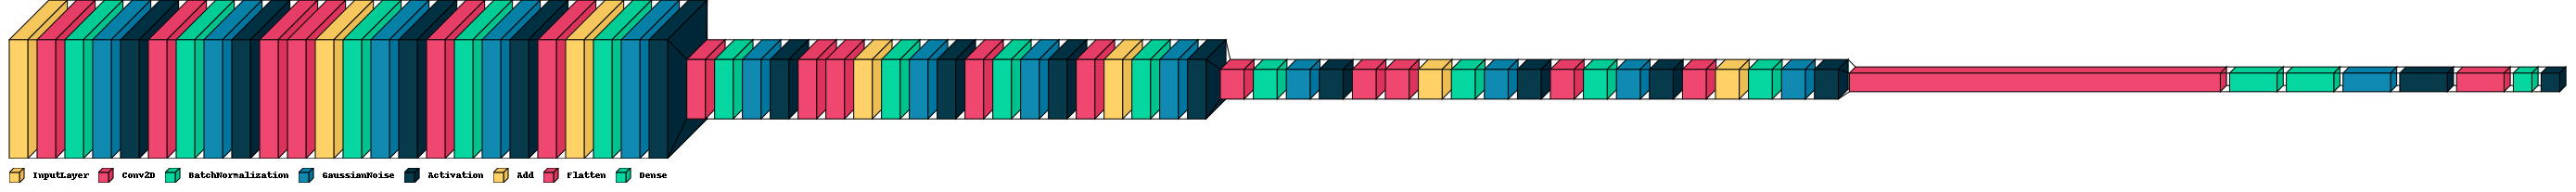

In [10]:
visualkeras.layered_view(model,legend=True)

In [11]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 32, 32, 16)   448         ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 32, 32, 16)  64          ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                                  
 gaussian_noise (GaussianNoise)  (None, 32, 32, 16)  0           ['batch_normalization[0][0]']

In [16]:

## OPTIM AND COMPILE
opt = Adam()
model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

In [17]:

history=model.fit(datagen.flow(x_train, y_train,batch_size=batch_size),
                            steps_per_epoch=len(x_train) / batch_size, 
                            epochs=epochs,
                            validation_data=(x_test, y_test),
                            verbose=1)

## TEST
scores = model.evaluate(x_test, y_test, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

Epoch 1/50
500/500 [==============================] - 44s 84ms/step - loss: 1.6332 - accuracy: 0.4052 - val_loss: 1.5734 - val_accuracy: 0.4838
Epoch 2/50
500/500 [==============================] - 40s 81ms/step - loss: 1.2162 - accuracy: 0.5629 - val_loss: 2.5633 - val_accuracy: 0.4152
Epoch 3/50
500/500 [==============================] - 40s 81ms/step - loss: 1.0024 - accuracy: 0.6451 - val_loss: 1.0726 - val_accuracy: 0.6533
Epoch 4/50
500/500 [==============================] - 41s 82ms/step - loss: 0.8644 - accuracy: 0.6972 - val_loss: 1.3300 - val_accuracy: 0.6006
Epoch 5/50
500/500 [==============================] - 41s 82ms/step - loss: 0.7829 - accuracy: 0.7259 - val_loss: 1.2277 - val_accuracy: 0.6511
Epoch 6/50
500/500 [==============================] - 43s 87ms/step - loss: 0.7213 - accuracy: 0.7492 - val_loss: 1.0339 - val_accuracy: 0.6823
Epoch 7/50
500/500 [==============================] - 42s 84ms/step - loss: 0.6648 - accuracy: 0.7687 - val_loss: 0.6763 - val_accuracy:

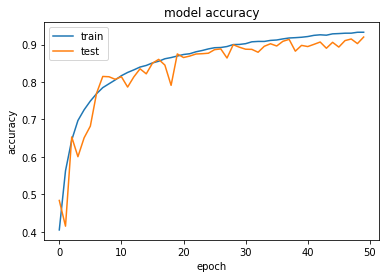

In [18]:
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()